In [1]:
import astropy.units as u

from altaipony.lcio import from_mast
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve


from lightkurve import search_targetpixelfile

import matplotlib.pyplot as plt
%matplotlib inline

import copy


from scipy.interpolate import UnivariateSpline

import os
import pandas as pd
import numpy as np

from funcs.funcs import read_custom_aperture_lc
from funcs.custom_detrending import custom_detrending

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
clcs = ! ls /home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/custom_aperture/*fits
clcs = [x.split("/")[-1] for x in clcs]

def get_customlc(TIC, c, clcs):
    for p in clcs:
        if (str(TIC) in p.split("-")[2]) & (c == int(p.split("-")[1][1:])):
            print(p)
            pac = p
    return pac

In [64]:
CWD = "/".join(os.getcwd().split("/")[:-1])
respath = f"{CWD}/flare_tables/2019_11_18_TESSUCDs_flares.csv"
df = pd.read_csv(respath)
targetswflare = df.TIC.unique().shape[0]
LCswflares = df.groupby(by=["TIC","Campaign"]).count().sort_values(by="ampl_rec").shape[0]
candidates = df.shape[0]
amplmax = df.ampl_rec.max()


14.340677261352502

In [33]:
df[df.Campaign==6].groupby("TIC").count()
TIC = 388857263
#df.groupby("TIC").Campaign.count().sort_values(ascending=False)[:10]
df[df.TIC==TIC].Campaign.unique()
#df.sort_values(by="ed_rec", ascending=False).head()

array([11, 12])

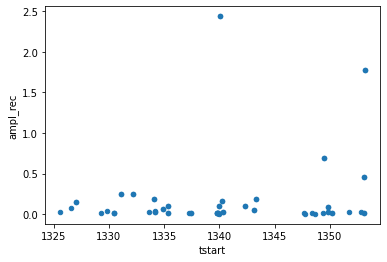

In [34]:
df[df.Campaign==1].plot(kind="scatter",x="tstart",y="ampl_rec")

In [40]:
c=12
plt.figure(figsize=(16,5))

path = get_customlc(TIC, c, clcs)

path = f"{CWD}/custom_aperture/" + path

flc = read_custom_aperture_lc(path)
#plt.plot(flc.time, flc.flux, c= "k")

flcd = custom_detrending(flc)
flcd = flcd.find_flares()
#plt.xlim(1394.5,1395.5)
#plt.xlim(1660,1670)
#plt.ylim(-1e14,1e14)
flcd.flares.sort_values(by="ed_rec",ascending=False)


175ca_tess2019100215271-s0012-0000000388857263-0000-s_lc.fits
Found peak in periodogram at  0.5 1 / d
SNR at  1.7144672439360955
Found peak in periodogram at  0.7022958993500983 1 / d
SNR at  1.490611389777483
Window lengths:  [75, 75]


/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/tessenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/custom_aperture/175ca_tess2019100215271-s0012-0000000388857263-0000-s_lc.fits' mode='rb' closefd=True>
  


Do last SavGol round.


Found 11 candidate(s) in the (0,9796) gap.
Found 20 candidate(s) in the (9796,19003) gap.


,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop
29,0.023196,305808,305823,20.457095,0.297767,18496,18511,19003.0,1652.192376,1652.213209
6,0.030386,292177,292195,19.965403,0.297691,5742,5760,19003.0,1633.260825,1633.285825
10,0.020160,295366,295380,18.747327,0.283083,8879,8893,19003.0,1637.689941,1637.709385
16,0.034919,297908,297923,17.282578,0.258472,10627,10642,19003.0,1641.220423,1641.241256
0,0.049665,286484,286499,17.057703,0.458158,175,190,19003.0,1625.353924,1625.374757
23,0.029824,302903,302915,15.812012,0.246482,15598,15610,19003.0,1648.157766,1648.174433
22,0.021967,302286,302304,14.577080,0.237110,14981,14999,19003.0,1647.300844,1647.325843
27,0.025291,305117,305128,13.773893,0.143731,17805,17816,19003.0,1651.232683,1651.247960
5,0.007653,291791,291809,11.280507,0.354746,5356,5374,19003.0,1632.724718,1632.749718
9,0.008805,294439,294453,11.231505,0.313970,7984,7998,19003.0,1636.402458,1636.421903


<Figure size 1152x360 with 0 Axes>

(136000.0, 140000.0)

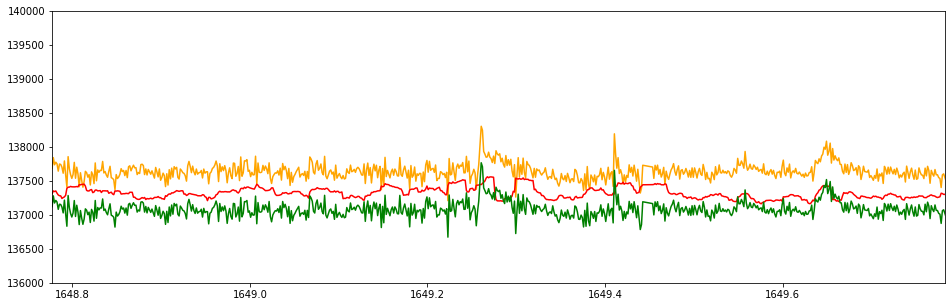

In [44]:
plt.figure(figsize=(16,5))
g = 14

plt.plot(flc.time, flc.flux+g*40, c="orange");#flc.time, 
plt.plot(flcd.time,flcd.it_med+3*flcd.detrended_flux_err, c="r");
plt.plot(flcd.time,flcd.detrended_flux, c="g");
f = flcd.flares.iloc[25]
plt.xlim(f.tstart-.5,f.tstop+.5);
plt.ylim(1.36e5,1.4e5)
#plt.xlim(1480,1482)

In [ ]:
#tpf = search_targetpixelfile("TIC" + str(flcd.targetid), sector=c).download()

In [ ]:
#tpf.interact()

In [ ]:
markers =  ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

358108509 1 last flare suffers from de-trending being weird at the end of the LC
340703996 2 first flare could also be an undetrended wiggle in the LC